<a href="https://colab.research.google.com/github/donghwi2022/ds-section2-project/blob/main/section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 0. 특성 설명** 

- **targets**
    - `Outcome` - 해당 게임의 승패 여부

- **features**
    - `Team` - 소속 팀 → 크루원 데이터만 남기고 해당 컬럼은 삭제
        - Crewmate : 크루원 
        - Imposter : 임포스터 
    - `Task Completed` - 완료한 업무 수 
    - `All Tasks Completed` - 모든 업무를 완료했는지 여부
    - `Murdered` - 임포스터에게 살해당했는지 여부  
    - `Game Length` - 게임 시간 (단위 : 초)
    - `Ejected` - 투표로 퇴출되었는지 여부 
    - `Sabotages Fixed` - 사보타지 고친 횟수            
    - `Time to complete all tasks` - 모든 업무 완료까지 걸린 시간 (단위 : 초)        
    - `Game Completed Date` - 게임이 끝난 시각 → 해당 컬럼 삭제 예정        
    - `Imposter Kills` - 임포스터로 몇 명을 죽였는지 → 해당 프로젝트에서는 미사용
    - `Rank Change` - 게임 승패로 랭크 변화여부 → 해당 프로젝트에서는 미사용
    - `Region/Game Code` - 게임 진행 지역/게임 코드 → 해당 프로젝트에서는 미사용 

# **Part 1. 필요 라이브러리 및 데이터 로드**

- 필요 라이브러리 import 및 한글 깨짐문제 해결
- csv 파일 load

In [1]:
#한글 깨짐문제 해결, 실행 후 런타임 재시작
import matplotlib.pyplot as plt
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic');

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
# 필요 라이브러리 설치
!pip3 install xgboost # xgboot 모델
!pip3 install pdpbox # pdp plot
!pip install category_encoders # Encoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 11.6 MB/s 
     |████████████████████████████████| 133 kB 36.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=680de7fd41ab64e5f1f452a219b253b3c2583f49b9a0699a561a542d3f1aef7e
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.4 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from pdpbox.pdp import pdp_isolate, pdp_plot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 파일 경로로 필요 csv 파일 불러오기
url = "/content/drive/MyDrive/codestates/files/AmongUs_User.csv"
df = pd.read_csv(url)
df.head()

,Game Completed Date,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Imposter Kills,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks,Rank Change,Region/Game Code
0,12/13/2020 at 1:26:56 am EST,Crewmate,Win,3,No,Yes,-,07m 04s,No,2.0,-,++,NA / WYMSBF
1,12/13/2020 at 1:17:42 am EST,Crewmate,Loss,7,Yes,No,-,16m 21s,No,1.0,09m 48s,--,NA / WYMSBF
2,12/13/2020 at 12:57:47 am EST,Crewmate,Win,3,No,No,-,11m 33s,No,0.0,-,++,NA / WYMSBF
3,12/13/2020 at 12:41:55 am EST,Imposter,Win,-,-,-,2,08m 05s,No,NaN,-,+++,Europe / QIRTNF
4,12/13/2020 at 12:30:37 am EST,Crewmate,Loss,4,No,No,-,05m 10s,No,0.0,-,---,Europe / QIRTNF


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Game Completed Date         2227 non-null   object 
 1   Team                        2227 non-null   object 
 2   Outcome                     2227 non-null   object 
 3   Task Completed              2227 non-null   object 
 4   All Tasks Completed         2227 non-null   object 
 5   Murdered                    2227 non-null   object 
 6   Imposter Kills              2227 non-null   object 
 7   Game Length                 2227 non-null   object 
 8   Ejected                     2227 non-null   object 
 9   Sabotages Fixed             1761 non-null   float64
 10  Time to complete all tasks  2227 non-null   object 
 11  Rank Change                 1828 non-null   object 
 12  Region/Game Code            2227 non-null   object 
dtypes: float64(1), object(12)
memory 

# **Part 2. 데이터 전처리 및 EDA**

## **Part 2-1. 데이터 전처리 진행** 

In [8]:
# 사용하지 않는 특성 제거
df.drop(['Game Completed Date', 'Imposter Kills', 'Rank Change', 'Region/Game Code'], axis = 1, inplace = True)

# Team == 크루원에 대해서 진행할 것이기 때문에 해당 데이터만 추출후 해당 특성 제거
df_crew = df[df['Team'] == 'Crewmate'].copy()
df_crew.drop('Team', axis = 1, inplace = True)

# 데이터프레임 정보 확인
df_crew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 0 to 2226
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Outcome                     1761 non-null   object 
 1   Task Completed              1761 non-null   object 
 2   All Tasks Completed         1761 non-null   object 
 3   Murdered                    1761 non-null   object 
 4   Game Length                 1761 non-null   object 
 5   Ejected                     1761 non-null   object 
 6   Sabotages Fixed             1761 non-null   float64
 7   Time to complete all tasks  1761 non-null   object 
dtypes: float64(1), object(7)
memory usage: 123.8+ KB


In [9]:
# 결측치 확인
df_crew.isnull().sum()

Outcome                       0
Task Completed                0
All Tasks Completed           0
Murdered                      0
Game Length                   0
Ejected                       0
Sabotages Fixed               0
Time to complete all tasks    0
dtype: int64

In [10]:
# 중복값 확인
print('중복값의 개수 : ', df_crew.duplicated().sum())

# 중복값 제거
df_crew.drop_duplicates(inplace = True)
print('중복값 제거 후, 중복값의 개수 : ', df_crew.duplicated().sum())

중복값의 개수 :  101
중복값 제거 후, 중복값의 개수 :  0


In [11]:
# 분과 초가 혼합되어있는 시간 특성을 초 단위로 변경하는 함수 작성
def m_to_s(text) :
    if text == '-' :
        return np.nan # '-'는 업무를 다 끝내지 못해서 미기록
    else : 
        return int(text.split('m')[0]) * 60 + int(text.split('m')[1][:3])

# 시간 특성에 함수 적용
df_crew['Game Length'] = df_crew['Game Length'].apply(m_to_s)
df_crew['Time to complete all tasks'] = df_crew['Time to complete all tasks'].apply(m_to_s)

In [12]:
# 숫자 타입의 특성을 정수 타입으로 변환
df_crew['Sabotages Fixed'] = df_crew['Sabotages Fixed'].astype(int)
df_crew['Task Completed'] = df_crew['Task Completed'].astype(int)

# 특성들 데이터 타입 확인
df_crew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 0 to 2226
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Outcome                     1660 non-null   object 
 1   Task Completed              1660 non-null   int64  
 2   All Tasks Completed         1660 non-null   object 
 3   Murdered                    1660 non-null   object 
 4   Game Length                 1660 non-null   int64  
 5   Ejected                     1660 non-null   object 
 6   Sabotages Fixed             1660 non-null   int64  
 7   Time to complete all tasks  772 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 116.7+ KB


In [13]:
# 최종 변환 데이터 확인
df_crew.head()

,Outcome,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks
0,Win,3,No,Yes,424,No,2,NaN
1,Loss,7,Yes,No,981,No,1,588.0
2,Win,3,No,No,693,No,0,NaN
4,Loss,4,No,No,310,No,0,NaN
5,Loss,7,Yes,Yes,982,No,0,736.0


## **Part 2-2. EDA 진행**

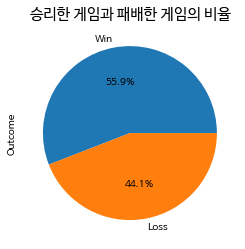

In [14]:
# 타겟의 데이터 분포 확인
df_crew['Outcome'].value_counts(normalize = True).plot.pie(autopct = "%.1f%%")
plt.title('승리한 게임과 패배한 게임의 비율', fontsize = 15)
plt.show()

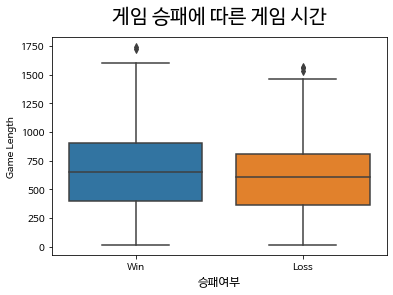

In [15]:
# Game Length 특성에 대해서 boxplot을 통해 시각화
sns.boxplot(x = 'Outcome', y = 'Game Length', data = df_crew)
plt.title('게임 승패에 따른 게임 시간', fontsize = 20, pad = 15)
plt.xlabel('승패여부', fontsize = 12)
plt.show()

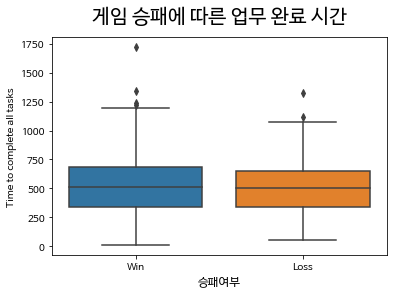

In [16]:
# Time to complete all tasks 특성에 대해서 boxplot을 통해 시각화
sns.boxplot(x = 'Outcome', y = 'Time to complete all tasks', data = df_crew)
plt.title('게임 승패에 따른 업무 완료 시간', fontsize = 20, pad = 15)
plt.xlabel('승패여부', fontsize = 12)
plt.show()

In [17]:
# 특성에 따라 승리, 패배 횟수 barplot을 그리는 함수 작성
def feature_outcome(df, target, rvs) : 
    bar_width = 0.25
    target_list = sorted(df[target].unique(), reverse = rvs)
    index = np.arange(len(target_list))
    for i in index : 
        plt.bar(i, df_crew[df_crew[target] == target_list[i]]['Outcome'].value_counts()['Win'], bar_width, alpha=0.7, color='blue')
        plt.bar(i + bar_width, df_crew[df_crew[target] == target_list[i]]['Outcome'].value_counts()['Loss'], bar_width, alpha=0.8, color='red')
    plt.xticks(np.arange(bar_width/2, len(target_list) + bar_width/2, 1), target_list)
    plt.xlabel(target, size = 13)
    plt.title(target + '에 따른 승리/패배 횟수', fontsize = 15)
    plt.legend(('Win', 'Loss'), bbox_to_anchor = (1, 1))
    plt.show()

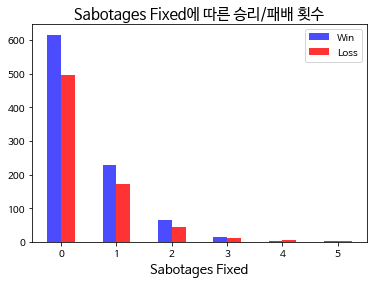

In [18]:
feature_outcome(df_crew, 'Sabotages Fixed', False)

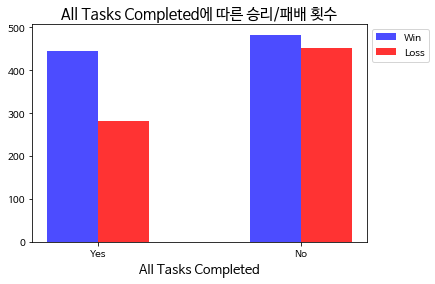

In [19]:
feature_outcome(df_crew, 'All Tasks Completed', True)

# **Part 3. 머신러닝**

In [20]:
# 타겟 설정
target = 'Outcome'

# 데이터를 훈련 데이터와 테스트 데이터로 분류
train_set, test_data = train_test_split(df_crew, test_size = 0.2, stratify = df_crew[target], random_state = 42)

# 훈련 데이터를 훈련 데이터와 검증 데이터로 분류
train_data, val_data = train_test_split(train_set, test_size = 0.2, stratify = train_set[target], random_state = 42)

print('훈련 데이터셋 : ', train_data.shape)
print('검증 데이터셋 : ', val_data.shape)
print('테스트 데이터셋 : ', test_data.shape)

훈련 데이터셋 :  (1062, 8)
검증 데이터셋 :  (266, 8)
테스트 데이터셋 :  (332, 8)


In [21]:
# 각 데이터를 feature과 label로 분리
features = train_data.drop(columns=[target]).columns

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]
y_test = test_data[target]

print('훈련 데이터 : ', X_train.shape, y_train.shape)
print('검증 데이터 : ', X_val.shape, y_val.shape)
print('테스트 데이터 : ', X_test.shape, y_test.shape)

훈련 데이터 :  (1062, 7) (1062,)
검증 데이터 :  (266, 7) (266,)
테스트 데이터 :  (332, 7) (332,)


In [22]:
# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print('기준모델의 정확도 :', baseline_acc.round(2))

기준모델의 정확도 : 0.56


In [23]:
# 특성 인코딩 
enc = OrdinalEncoder()

X_train_encoded = enc.fit_transform(X_train)
X_val_encoded = enc.transform(X_val)
X_test_encoded = enc.transform(X_test)

X_train_encoded.head()

,Task Completed,All Tasks Completed,Murdered,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks
1647,7,1,1,652,1,1,NaN
2123,5,2,1,666,2,2,493.0
1995,8,2,2,1217,1,1,314.0
2010,3,1,1,462,1,0,NaN
427,2,1,2,472,1,0,NaN


In [24]:
# 모델 생성
model =  XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "error",  # 회귀 : rmse / 분류 : error
        n_estimators = 200,
        random_state = 42,
        gamma = 2,
        n_jobs = -1,
        learning_rate = 0.1
    )


In [25]:
# 탐색할 하이퍼 파라미터 설정
params = {
    "xgbclassifier__max_depth": [2, 3, 4, 5, 6],
    "xgbclassifier__min_child_weight": np.arange(1, 11),
    "xgbclassifier__sub_sample": [0.2, 0.4, 0.6, 0.8, 1]
}

# 하이퍼 파라미터 탐색
grid_search = GridSearchCV(model, param_grid = params, scoring = "accuracy", cv = 3, verbose = 3)
grid_search.fit(X_train_encoded, y_train)

print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 정확도: ", grid_search.best_score_)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV 1/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.2;, score=0.619 total time=   0.2s
[CV 2/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.2;, score=0.621 total time=   0.1s
[CV 3/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.2;, score=0.599 total time=   0.1s
[CV 1/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.4;, score=0.619 total time=   0.1s
[CV 2/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.4;, score=0.621 total time=   0.1s
[CV 3/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.4;, score=0.599 total time=   0.1s
[CV 1/3] END xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0

In [26]:
# 최적의 하이퍼 파라미터로 학습 진행
model_best = grid_search.best_estimator_
model_best.fit(X_train_encoded, y_train)

# 훈련데이터와 검증 데이터의 정확도 비교
y_pred = model_best.predict(X_train_encoded)
print('훈련데이터 기준 모델 정확도 : ', accuracy_score(y_train, y_pred).round(3))

y_pred = model_best.predict(X_val_encoded)
print('검증데이터 기준 모델 정확도 : ', accuracy_score(y_val, y_pred).round(3))

훈련데이터 기준 모델 정확도 :  0.675
검증데이터 기준 모델 정확도 :  0.605


In [27]:
# 테스트 데이터를 사용하여 모델의 일반화 성능 확인
y_pred = model_best.predict(X_test_encoded)
print('테스트데이터 기준 모델 정확도 : ', accuracy_score(y_test, y_pred).round(3))
print()

# Classification Report를 통해 각 class에 대한 성능 평가 결과를 확인
print('     Classification Report를 사용하여 성능 확인')
print(classification_report(y_test, y_pred))

테스트데이터 기준 모델 정확도 :  0.636

     Classification Report를 사용하여 성능 확인
              precision    recall  f1-score   support

        Loss       0.61      0.48      0.54       146
         Win       0.65      0.76      0.70       186

    accuracy                           0.64       332
   macro avg       0.63      0.62      0.62       332
weighted avg       0.63      0.64      0.63       332



Text(0.5, 1.0, 'Confusion Matrix (n = 332)')

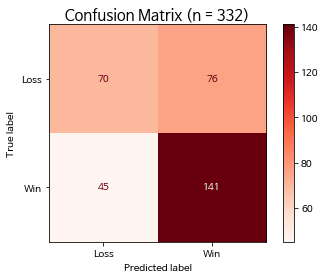

In [28]:
# Confusion Matrix를 계산하여 직관적으로 모델의 예측 결과를 확인
plot_confusion_matrix(model_best, X_test_encoded, y_test, cmap = plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_test)})", fontsize=15)

# **Part 4. ML모델 해석**

## **Part 4-1. Feature Importance(특성 중요도)**

In [29]:
# Drop-Column Importance를 사용하여 특성 중요도 확인
score = model_best.score(X_test_encoded, y_test)
print(f'Before Drop :: 정확도 {score:.3f}')

dci = pd.Series(dtype = float)

for feature in features:
    p = model_best
    p.fit(X_train_encoded.drop(columns=[feature], axis=1), y_train)
    score_dropped = p.score(X_test_encoded.drop(columns=[feature], axis=1), y_test)
    print(f"Drop {feature} :: 정확도 {score_dropped:.3f}")

    dci[feature] =  score - score_dropped

Before Drop :: 정확도 0.636
Drop Task Completed :: 정확도 0.639
Drop All Tasks Completed :: 정확도 0.636
Drop Murdered :: 정확도 0.554
Drop Game Length :: 정확도 0.645
Drop Ejected :: 정확도 0.614
Drop Sabotages Fixed :: 정확도 0.623
Drop Time to complete all tasks :: 정확도 0.639


Text(0.5, 1.0, 'Drop-Column Importance')

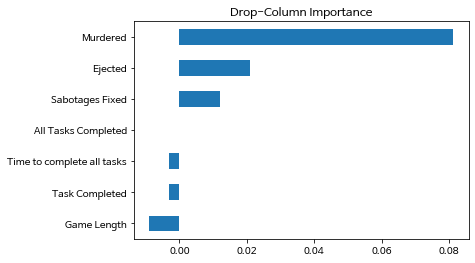

In [30]:
dci.sort_values().plot.barh()
plt.title("Drop-Column Importance")

### **결과 요약** <br>
해당 예측 모델에서 중요한 특성 순위 <br>
1. Murdered - 임포스터에게 살해당했는지 여부
2. Ejected - 투표로 퇴출되었는지 여부
3. Sabotages Fixed - 사보타지 고친 횟수
4. All Tasks Completed - 모든 업무를 완료했는지 여부
5. Time to complete all tasks - 모든 업무 완료까지 걸린 시간
6. Task Completed - 완료한 업무 수
7. Game Length - 게임 시간

## **Part 4-2. PDP**

특성 중요도에서 해당 특성을 drop했을 때, 성능이 감소하는 특성에 대해 진행 <br>
해당 특성 : Murdered, Time to complete all tasks, Ejected

In [31]:
# Part 4-1에서 특성을 드랍하고 학습을 진행했기 때문에 다시 원래 데이터로 학습 진행
model_best.fit(X_train_encoded, y_train)

XGBClassifier(eval_metric='error', gamma=2, n_estimators=200, n_jobs=-1,
              random_state=42, xgbclassifier__max_depth=2,
              xgbclassifier__min_child_weight=1, xgbclassifier__sub_sample=0.2)

In [32]:
# 매핑한 정보 확인
mappings = enc.mapping 
mappings

[{'col': 'All Tasks Completed', 'mapping': No     1
  Yes    2
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'Murdered', 'mapping': No     1
  Yes    2
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'Ejected', 'mapping': No     1
  Yes    2
  NaN   -2
  dtype: int64, 'data_type': dtype('O')}]

In [33]:
# PDP를 그려주는 함수 작성
def draw_pdp(feature, remove_nan = False, do_mapping = False) : 
    target_feature = feature
    dataset = X_test_encoded

    # 결측치를 제거여부
    if remove_nan == True :
        dataset = X_test_encoded.dropna()

    # PDP 작성
    isolated = pdp_isolate(
        model = model_best,
        dataset = dataset,
        model_features = X_test.columns,
        feature = target_feature,
        grid_type="percentile"
        )
    
    pdp_plot(isolated, feature_name = target_feature)

    # 인코딩하기 전 특성값 가져오기
    if do_mapping == True :
        mappings = enc.mapping
        mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
        maps = mapping_data[0]["mapping"]
        encoded_features = maps.values.tolist()[:2]
        original_features = maps.index.tolist()[:2]
        plt.xticks(encoded_features, original_features)

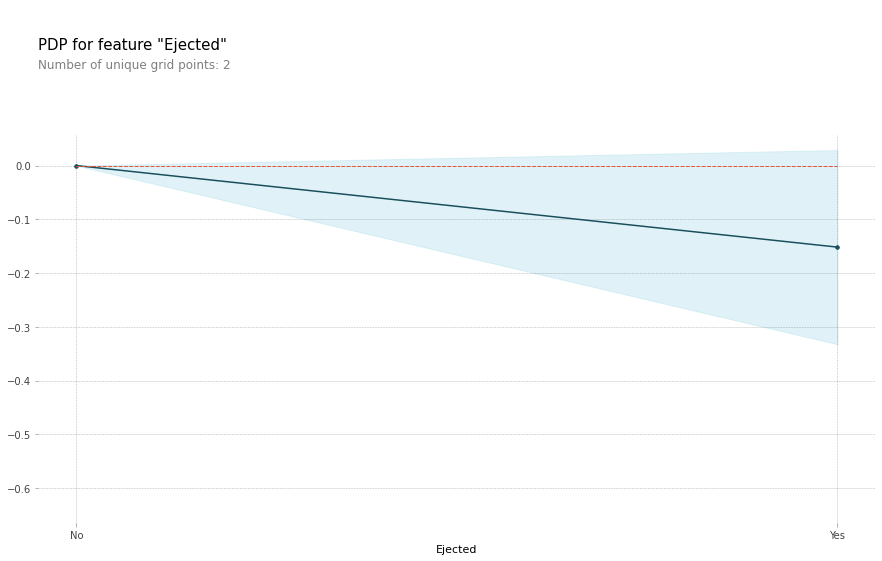

In [34]:
draw_pdp('Ejected', do_mapping = True)

**PDP 해석** : 임포스터에게 살해당하면 승리할 확률이 약 18% 감소한다.

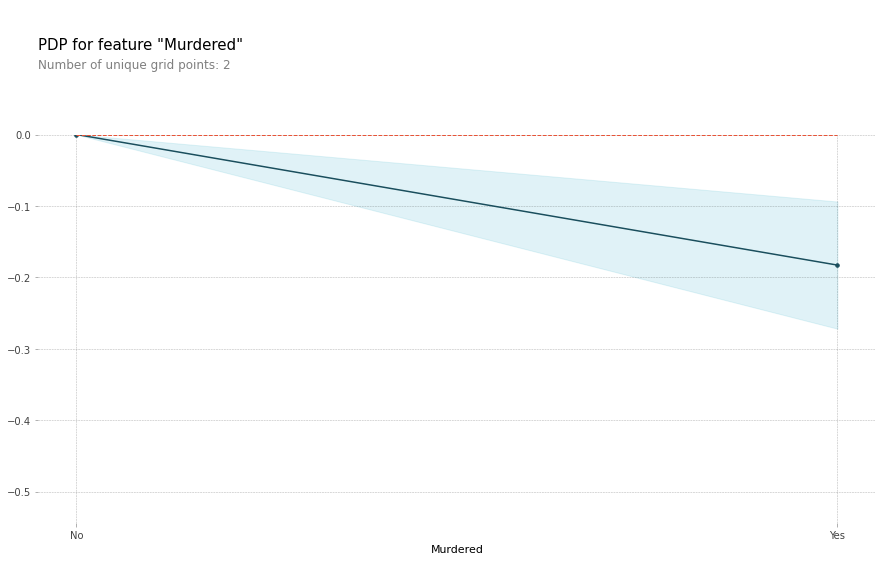

In [35]:
draw_pdp('Murdered', do_mapping = True)

**PDP 해석** : 퇴출되면 승리할 확률이 약 15% 감소한다.

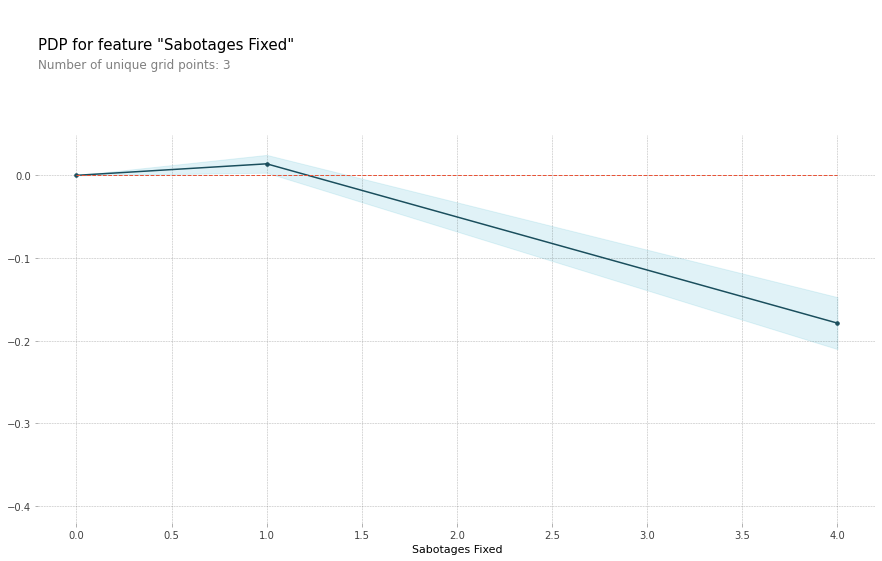

In [37]:
draw_pdp('Sabotages Fixed', remove_nan = True)

**PDP 해석** : 사보타지 고친 횟수가 1까지는 승률이 상승하지만, 그 이상이 되면 승률이 하락한다. <br>
**주의사항** : 데이터가 0, 1, 4인 경우밖에 없기 때문에 신뢰하기 어렵다.